In [7]:
import imgaug.augmenters as iaa
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd

In [8]:
original_images = []
original_angles = []
images_path = glob.glob("/home/pi/deepcar/car/images/*.jpeg")



for img_path in images_path:
    print(img_path)
    img = cv2.imread(img_path)
    original_images.append(img)
    original_angles.append(int(img_path.split(".")[0][-3:]))

/home/pi/deepcar/car/images/63028d73_154_035.jpeg
/home/pi/deepcar/car/images/63028d73_148_079.jpeg
/home/pi/deepcar/car/images/63028d73_106_075.jpeg
/home/pi/deepcar/car/images/63028d73_19_089.jpeg
/home/pi/deepcar/car/images/63028d73_115_087.jpeg
/home/pi/deepcar/car/images/63028d73_3_041.jpeg
/home/pi/deepcar/car/images/63028d73_28_083.jpeg
/home/pi/deepcar/car/images/63028d73_140_084.jpeg
/home/pi/deepcar/car/images/63028d73_109_083.jpeg
/home/pi/deepcar/car/images/63028d73_42_035.jpeg
/home/pi/deepcar/car/images/63028d73_56_090.jpeg
/home/pi/deepcar/car/images/63028d73_123_039.jpeg
/home/pi/deepcar/car/images/6aa394e8_2_101.jpeg
/home/pi/deepcar/car/images/63028d73_8_035.jpeg
/home/pi/deepcar/car/images/63028d73_17_078.jpeg
/home/pi/deepcar/car/images/63028d73_48_073.jpeg
/home/pi/deepcar/car/images/63028d73_18_089.jpeg
/home/pi/deepcar/car/images/63028d73_40_072.jpeg
/home/pi/deepcar/car/images/63028d73_122_076.jpeg
/home/pi/deepcar/car/images/63028d73_52_090.jpeg
/home/pi/deepca

In [9]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image


def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = iaa.Multiply((0.6, 1.4))
    image = brightness.augment_image(image)
    return image


def blur(image):
    # kernel larger than 5 would make the image way too blurry
    kernel_size = random.randint(1, 5)
    image = cv2.blur(image, (kernel_size, kernel_size))

    return image


def flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = 180 - steering_angle

    return image, steering_angle

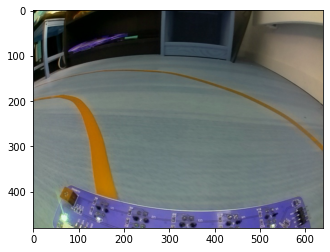

In [10]:
plt.imshow(original_images[0])

In [11]:
print(original_angles[0])

35


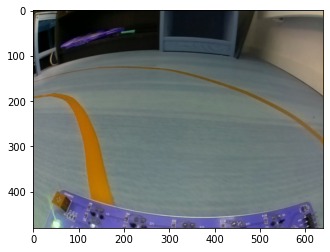

In [12]:
plt.imshow(zoom(original_images[0]))

In [13]:
mirror_images = []
mirror_angles = []

for pair in zip(original_images, original_angles):
    img, ang = flip(pair[0], pair[1])
    mirror_images.append(img)
    mirror_angles.append(ang)


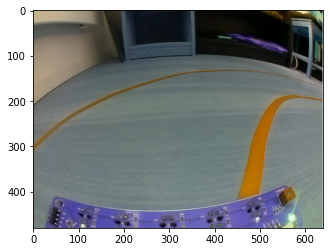

In [14]:
plt.imshow(mirror_images[0])

In [15]:
mirror_angles[0]

145

In [16]:
print("Original: ", len(original_images))
print("Mirror: ", len(mirror_images))

Original:  168
Mirror:  168


In [17]:
all_images = np.concatenate((original_images, mirror_images))
all_angles = np.concatenate((original_angles, mirror_angles))

In [18]:
all_images.shape

(336, 480, 640, 3)

Anmerkung: Müssen Bilder so groß sein?

Evtl. lohnt sich ein reshapen, z.B. auf 240x320

In [19]:
all_angles.shape

(336,)

### Ein Blick auf Histogramm der Winkel

<AxesSubplot:>

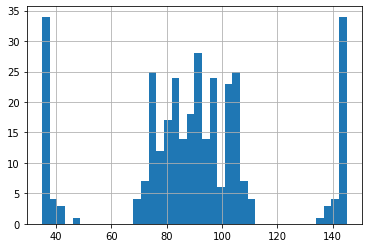

In [20]:
pd.Series(all_angles, name ='angles').hist(bins = 40)

## Vorbereitung Tensorflow

- Es muss die Shape passen für Tensorflow (Anzahl Bilder, Höhe, Breite, Anzahl Farbkanäle)
- Standardisieren/Normalisieren der Pixelwerte
- Train Test Split
- Überlegen wie die letzte Schicht aussehen muss (Anzahl der Outputs, Aktivierungfunktion). Was muss vorhergesagt werden?

Nicht alle diese Schritte werden hier durchgeführt!


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
#from sklearn.model_selection import train_test_split

In [23]:
X_train = all_images[:300]
y_train = all_angles[:300]

X_test = all_images[300:]
y_test = all_angles[300:]

In [24]:
n, h, w, f = all_images.shape
input_shape = (h, w, f)
print(input_shape)

(480, 640, 3)


In [25]:
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


2023-03-14 08:40:32.880388: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 86400 exceeds 10% of free system memory.
2023-03-14 08:40:32.885445: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 86400 exceeds 10% of free system memory.
2023-03-14 08:40:32.886426: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 86400 exceeds 10% of free system memory.
2023-03-14 08:40:32.922683: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 172800 exceeds 10% of free system memory.
2023-03-14 08:40:32.924341: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 172800 exceeds 10% of free system memory.


In [26]:
model.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 318, 24)      1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 157, 36)      21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 75, 64)        27712     
_________________________________________________________________
dropout (Dropout)            (None, 55, 75, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 53, 73, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 247616)            0       

In [27]:
model.compile(loss ='mse', optimizer=Adam(learning_rate=0.001))

In [28]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 1,
    verbose=1,
)

2023-03-14 08:40:35.817019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-14 08:40:35.842792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


: 

: 

In [ ]:
def train_loss_acc_plot(history):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

In [ ]:
train_loss_acc_plot(history)

In [ ]:
mse_train = model.evaluate(X_train, y_train)
mse_test = model.evaluate(X_test, y_test)

In [ ]:
# Visualisierung der Fehler
y_train_p = model.predict(X_train)
y_test_p = model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(y_train, y_train_p, 'rx', ms=2)
plt.plot([45,135], [45,135], 'k-')
plt.subplot(122)
plt.plot(y_test, y_test_p, 'bx', ms=2)
plt.plot([45,135], [45,135], 'k-')

In [ ]:
model.save('test.h5')

In [ ]:
model_loaded = tf.keras.models.load_model('test.h5')

In [ ]:
xe = np.array( [X_train[0]] )
xe.shape

In [ ]:
model_loaded.predict(xe)

In [ ]:
model_loaded(xe).numpy()

In [ ]:
# langsam
%timeit 
model_loaded.predict(xe)

In [ ]:
# schneller
%timeit 
model_loaded(xe).numpy()